In [30]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="../data/test/pal", split="train")

Generating train split: 107 examples [00:00, 6293.96 examples/s]


In [31]:
from torchvision import transforms

resize_remove_alfa = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert("RGB")),
])
resized_no_alfa = dataset.map(lambda example: {"image": resize_remove_alfa(example["image"])}, batched=False)

Map:   0%|          | 0/107 [00:00<?, ? examples/s]

Map: 100%|██████████| 107/107 [00:02<00:00, 51.54 examples/s] 


In [32]:
from torchvision import transforms

compose = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
composed = resized_no_alfa.map(lambda example: {"image": compose(example["image"])}, batched=False)
composed.set_format("torch")

Map:   0%|          | 0/107 [00:00<?, ? examples/s]

Map: 100%|██████████| 107/107 [00:11<00:00,  9.39 examples/s] 


In [33]:
from safetensors import safe_open
from torchvision import models, transforms
import torch

labels = ["pal", "pokemon"]

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(labels))

model_save_path = "../models/snapshots/ResNet18_FineTuned_epoch5_10.safetensors"
tensors = {}
with safe_open(model_save_path, framework="pt", device="cpu") as f:
    for key in f.keys():
        tensors[key] = f.get_tensor(key)

model.load_state_dict(tensors, strict=False)
model.eval()

c:\Users\hiroga\miniconda3\envs\pokemon-palworld-v2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hiroga\miniconda3\envs\pokemon-palworld-v2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
index = 11

In [48]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from torchvision import transforms
import numpy as np
import torch

target_layers = [model.layer4[-1]]
# Note: input_tensor can be a batch tensor with several images!

input_tensor = composed["image"][index:index+1]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...`````

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# マジで仕様がよく分からなくて、grayscase_camsの長さはバッチサイズに依存するのに、中身が入っているかどうかはtargetsに依存する。
grayscale_cams = cam(input_tensor=input_tensor, targets=targets) # (batch_size, height, widgh)

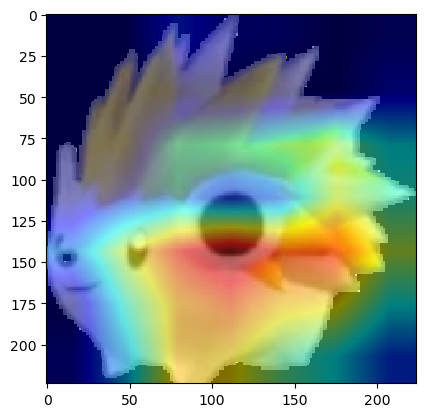

In [49]:
import numpy as np
import matplotlib.pyplot as plt

for cam in grayscale_cams:
    rgb_img = np.array(resized_no_alfa[index]["image"]) / 255.0 # (height, width, channel) の順である必要がある。ex. 224, 224, 3
    visualization = show_cam_on_image(rgb_img, cam, use_rgb=True)
    plt.imshow(visualization, vmin=0, vmax=255, interpolation='none')
    plt.show()